# Crypto currency Demystified
## Final Project: Computing for Analytics
## Group: C1G4
#### Deepika Jindal | Nelson (Hung-Ju) Chou | Shubhansh Jain | Shengie Guo | Udaiveer Singh Chauhan | Arjun Chakraborty

### Importing Packages

In [1]:
import pandas as pd
import statsmodels.formula.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrices
import warnings
import datetime
import copy
import cProfile
from scipy import stats
from time import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')

## Part 1: Function Definations
- a unction to read the raw dat anad merge them
- a function to run regression for top N currencies and print the summaries
- a function to measure time 
- a function to calculate the VIF adn multicolinearity in a regression model
- a function to reun gregressino fon n variables and return a dataframe of all beta variables

In [2]:
%time
def read_Data():
#########################
#1. Read relevant data sources, including cyptocurrency prices, SP500, and Gold Price
#########################
    df_Currency=pd.read_csv('all_currencies.csv')
    df_SP500=pd.read_csv('S&P 500 Index Historical Stock Prices.csv')
#First row contains strange information, we remove the 1st row
    df_SP500=df_SP500.iloc[1:]

#Create new column with the same date format
    df_SP500['DateNew']=pd.Series()

    for i in range(len(df_SP500)):
        df_SP500['DateNew'].iloc[i]=str(df_SP500['date'].iloc[i])[0:4]+'-'+str(df_SP500['date'].iloc[i])[5:7]+'-'+str(df_SP500['date'].iloc[i])[8:]

#Read gold price based on the sheet we want
#https://www.gold.org/research/download-the-gold-price-since-1978#
    df_GoldPrice=pd.read_excel('Prices.xls', sheet_name='Daily', skiprows=8)
    df_GoldPrice=df_GoldPrice[['Name', 'US dollar']]

# #########################
#2. Data cleaning
# #########################

#Rename column name
    df_GoldPrice.rename(columns={'Name':'Date'}, inplace=True)
    df_Currency.rename(columns={'Market Cap':'Market_Cap'}, inplace=True)
    df_Currency.rename(columns={'Open':'Open_Price'}, inplace=True)

#Convert date column datatype to string
    df_GoldPrice['DateNew']=df_GoldPrice['Date'].dt.strftime('%Y-%m-%d')

#Take out data without volume and market cap info
    df_Currency=df_Currency[df_Currency.Volume.isna()==False]
    df_Currency=df_Currency[df_Currency['Market_Cap'].isna()==False]
    
#Creating final dataframe by merging SP500 and Gold Price datasets with Cryptocurrency dataset using date as the common column
    df_CurrencyMerged=pd.DataFrame(df_Currency.merge(df_SP500, left_on='Date', right_on='DateNew', how='inner')) 
    df_CurrencyMerged=pd.DataFrame(df_CurrencyMerged.merge(df_GoldPrice, left_on='Date', right_on='DateNew', how='inner'))

#taking subset of the final dataframe for performing regression and renaming columns
    df_CurrencyMerged=df_CurrencyMerged[['Date_x', 'Symbol', 'Open_Price', 'Low', 'close', 'Volume', 'Market_Cap', 'US dollar']]
    df_CurrencyMerged.rename(columns={'Date_x':'Date', 'close':'SP500ClosePrice','US dollar':'Gold_Price'},inplace=True)
    return(df_CurrencyMerged)

Wall time: 0 ns


In [3]:
def regressForN(df_CurrencyMerged,n):

#Select top n currencies based on max Market_Cap in the past years
    sr_TopCurrency=df_CurrencyMerged.groupby(['Symbol'])['Market_Cap'].max()
    sr_TopCurrency=sr_TopCurrency.sort_values(ascending=False)
    sr_TopnCurrency=sr_TopCurrency[:n]
    ls_Symbols=[]
    for i in range(len(sr_TopnCurrency)):
        ls_Symbols.append(sr_TopnCurrency.index[i])
        df_TopnCurrency=pd.DataFrame(ls_Symbols)

#Merge the dataset to have dataset of top n currencies only
    df_CurrencyMerged=pd.DataFrame(df_CurrencyMerged.merge(df_TopnCurrency, left_on='Symbol', right_on=0, how='inner'))
    
#Performing regression for each of the top (n) currencies
    df_ForEachCurrency=pd.DataFrame()
    for i in range(len(ls_Symbols)):
        df_4Currencyi=pd.DataFrame([ls_Symbols[i]])
        df_ForEachCurrency=pd.DataFrame(df_CurrencyMerged.merge(df_4Currencyi, left_on='Symbol', right_on=0, how='inner'))

#########################
#3. Run regression
#########################

        print('################### Regression Model For Currency: ',ls_Symbols[i],'###################')
        result= sm.ols(formula="Market_Cap ~ Volume+Open_Price+SP500ClosePrice+Gold_Price", data=df_ForEachCurrency).fit()
        print (result.summary(),'\n')    

In [4]:
#Calculate VIF for a cryptocurrency
def calVIF(dataset,symbol):
    ls_Symbols=[symbol]
    df_CurrSym=pd.DataFrame(ls_Symbols)
    df_CurrencySym=pd.DataFrame(dataset.merge(df_CurrSym, left_on='Symbol', right_on=0, how='inner'))
    y, X = dmatrices("Market_Cap ~ Volume+Open_Price+SP500ClosePrice+Gold_Price", data=df_CurrencySym, return_type="dataframe")
# For each Xi, calculate VIF
    vif = [variance_inflation_factor(X.values, j) for j in range(X.shape[1])]
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, j) for j in range(X.shape[1])]
    vif["features"] = X.columns
    print(vif.round(2))

    for k in range(len(vif)):
        if float(vif.iloc[k][0])>=25:
            print('High multicollinearity: '+ vif.iloc[k][1])
        else:
            print('No multicollinearity: '+ vif.iloc[k][1]+'\n')

In [5]:
def RegresstoDF(dataset,Top_n): 
    di={}
    li=[]
    dfCurrency['Time_elapsed']=np.zeros(len(dfCurrency))

    srTopCurrency=dataset.groupby(["Symbol"])['Market_Cap'].max()
    srTop10Currency=srTopCurrency.sort_values(ascending=False)
    srTop10Currency=srTop10Currency[0:Top_n]
    lsSymbols=[]

    for i in range(len(srTop10Currency)):
        lsSymbols.append(srTop10Currency.index[i])


#Start to do regression, print a summary
    for i in lsSymbols:
        temp_df=dataset[dfCurrency.Symbol==i]
        result = sm.ols(formula="Market_Cap ~ Volume+Open_Price+Gold_Price+SP500ClosePrice", data=temp_df).fit()
        for k in result.pvalues.keys():
            di[k+' P_val']=result.pvalues[k]
        for k in result.params.keys():
            di[k]=result.params[k]

        li.append(copy.deepcopy(di))
    Data=pd.DataFrame(li)
    return Data

In [6]:
def ccRegress(dataset,symbol):    
    ls_Symbols=[symbol]
    df_CurrSym=pd.DataFrame(ls_Symbols)
    df_CurrencySym=pd.DataFrame(dataset.merge(df_CurrSym, left_on='Symbol', right_on=0, how='inner'))
    Y=np.array(df_CurrencySym.Market_Cap)
    X=np.vstack([np.ones(Y.shape[0]), np.array(df_CurrencySym.Volume), np.array(df_CurrencySym.Open_Price), np.array(df_CurrencySym.SP500ClosePrice), np.array(df_CurrencySym.Gold_Price)])
    A=np.linalg.inv(np.dot(X,X.T))
    B=np.dot(X,Y.T)
    C=np.dot(A,B)
    print(C)

In [7]:
def measureTime(fun,arg1,arg2):
    nTimes=50
    times=np.zeros(nTimes)
    for i in range(nTimes):
        startTime = time()    
        fun(arg1,arg2)
        endTime = time()
        times[i]=endTime-startTime
    return np.mean(times)

## Part 2: Understanding Normalised Trendlines for Gold price, Crypto, and S&P500

In [8]:
%%time

dfCurrency=read_Data()
compare=dfCurrency[['Date','Market_Cap','Symbol','Open_Price','Gold_Price','SP500ClosePrice']]

Wall time: 18.5 s


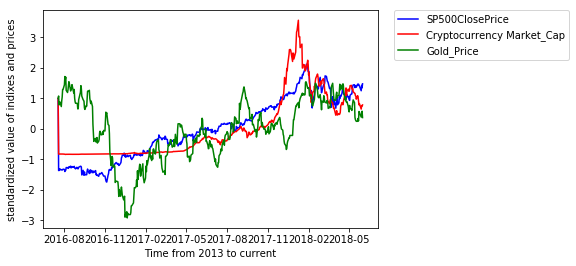

Wall time: 1.07 s


In [9]:
%%time

#Obtaining dataframes by grouping on Date  
grouped1=compare.groupby(["Date"])['Market_Cap'].sum()
grouped2=compare.groupby(["Date"])['Gold_Price'].mean()
grouped3=compare.groupby(["Date"])['SP500ClosePrice'].mean()
df_Grouped1=pd.DataFrame(grouped1)
df_Grouped1.reset_index(inplace=True)
df_Grouped2=pd.DataFrame(grouped2)
df_Grouped2.reset_index(inplace=True)
df_Grouped3=pd.DataFrame(grouped3)
df_Grouped3.reset_index(inplace=True)

#Merging to obtain final dataframe

data_fin=pd.DataFrame(df_Grouped1.merge(df_Grouped2, left_on='Date', right_on='Date', how='inner'))
data_fin=pd.DataFrame(data_fin.merge(df_Grouped3, left_on='Date', right_on='Date', how='inner'))

data_fin['Time_elapsed']=np.zeros(len(data_fin))

#Plotting the Trends Graph of cryptocurrency, oil prices and S&P500Prices
sc_item= StandardScaler()
data_fin.iloc[:,1:5]=sc_item.fit_transform(data_fin.iloc[:,1:5])

d=datetime.datetime.strptime(data_fin.iloc[0,0], '%Y-%m-%d')
for i, rows in data_fin.iterrows():
    data_fin.iloc[i,0]  = datetime.datetime.strptime(rows.iloc[0], '%Y-%m-%d')
    data_fin.iloc[i,1] = data_fin.iloc[i,1] /data_fin.iloc[0,1]
    data_fin.iloc[i,2] = data_fin.iloc[i,2] /data_fin.iloc[0,2]
    data_fin.iloc[i,3] = data_fin.iloc[i,3] /data_fin.iloc[0,3]
    delta= data_fin.iloc[i,0] -d
    data_fin.iloc[i,4]=delta.days
    
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot (data_fin['Date'], data_fin['SP500ClosePrice'], 'b-',linewidth=1.5,label="SP500ClosePrice")
ax1.plot (data_fin['Date'], data_fin['Market_Cap'], 'r-',linewidth=1.5,label="Cryptocurrency Market_Cap")
ax1.plot (data_fin['Date'], data_fin['Gold_Price'], 'g-',linewidth=1.5,label="Gold_Price")

plt.xlabel('Time from 2013 to current')
plt.ylabel('standardized value of indixes and prices')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Part 3: Market share distribution of Various crypto currencies
we compare the total market share of different currencies and find that in 2016 Bitcoin was the ,sot dominant one, but in 2018 there the market of the cryptocurrency has more options of investment, and the share of bitcoin has reduced a lot compared ot 2016

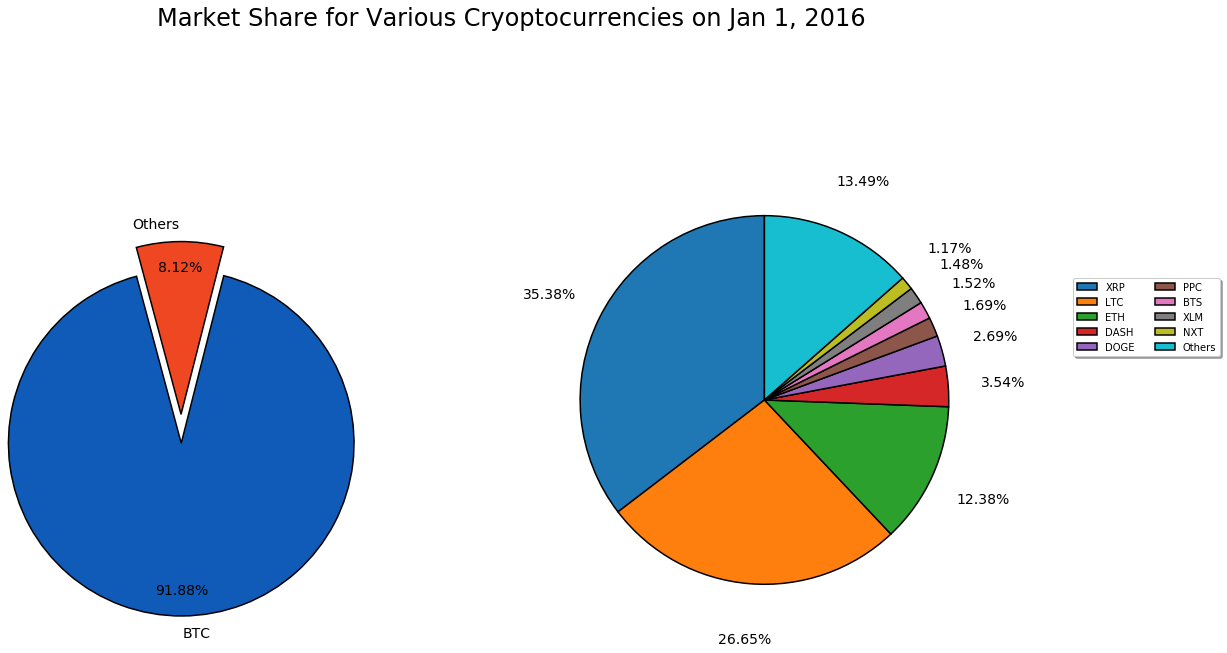

Wall time: 1.43 s


In [10]:
%%time
df_Currency=pd.read_csv('all_currencies.csv')
df_Currency.dropna(inplace=True)
df_2016 = df_Currency[df_Currency['Date'].str.contains("(?:\s|^)2016-01-01(?:\s|$)")]
df_2016 = df_2016.set_index('Symbol')

#Calculating fractional market Cap for each observation in 2016 currency data stored in df_2016
totalMarCap=sum(df_2016['Market Cap'])
df_Temp=pd.DataFrame({'Market Cap':df_2016['Market Cap'],'Fraction':df_2016['Market Cap']/totalMarCap})

# df_Temp.head()
df_High0=df_Temp[df_Temp.Fraction>0.1]
df_Low0=df_Temp[df_Temp.Fraction<=0.1]
df_High0.loc['Others']=df_Low0.sum(axis=0)
df_High0=df_High0.iloc[:,0:3]

# Removing Bitcoin and creating a dataframe with others
df_Temp2 = df_Temp.sort_values('Fraction',ascending=False)
df_Temp2 = df_Temp2.drop(index='BTC')
totalMarCap_wo_BTC=sum(df_Temp2['Market Cap'])
df_Temp2=pd.DataFrame({'Market Cap':df_Temp2['Market Cap'],'Fraction':df_Temp2['Market Cap']/totalMarCap_wo_BTC})
#newDF=pd.DataFrame()
df_High1=df_Temp2[df_Temp2.Fraction>0.011]
df_Low1=df_Temp2[df_Temp2.Fraction<=0.011]
df_High1.loc['Others']=df_Low1.sum(axis=0)
df_High1=df_High1.iloc[:,0:3]

# Plotting Pie Charts to show market share of cryptocurrencies on 1st Jan 2016 and creating another pie chart by removing Bitcoin
explode=(0,0.5)
colors = ['#105bb7', '#ef4721']
fig = plt.figure()
ax1 = fig.add_axes([0, 1.2, .5, .5], aspect=1)
ax1 = plt.pie(df_High0['Market Cap'], labels=df_High0.index,shadow=False, colors= colors, explode= explode, radius=3, startangle=105, autopct='%0.2f%%', pctdistance=0.85, textprops={'fontsize': 14}, wedgeprops={"edgecolor":"k",'linewidth': 1.5 , 'antialiased': True})
#ax1 = plt.annotate("",xy=(0,1),xytext=(4,1),arrowprops=dict(arrowstyle="<-"))
ax2 = fig.add_axes([1.2, 1.2, .8, .8], aspect=1) 
ax2 = plt.pie(df_High1['Market Cap'], shadow=False, radius=2, startangle=90, autopct='%0.2f%%', pctdistance=1.3, textprops={'fontsize': 14}, wedgeprops={"edgecolor":"k",'linewidth': 1.5 , 'antialiased': True})
plt.legend(df_High1.index,bbox_to_anchor=(2.5, 1.05),ncol=2, fancybox=True, shadow=True)
plt.title("Market Share for Various Cryoptocurrencies on Jan 1, 2016", fontsize=24, x=-0.6, y=2.1)
plt.show()

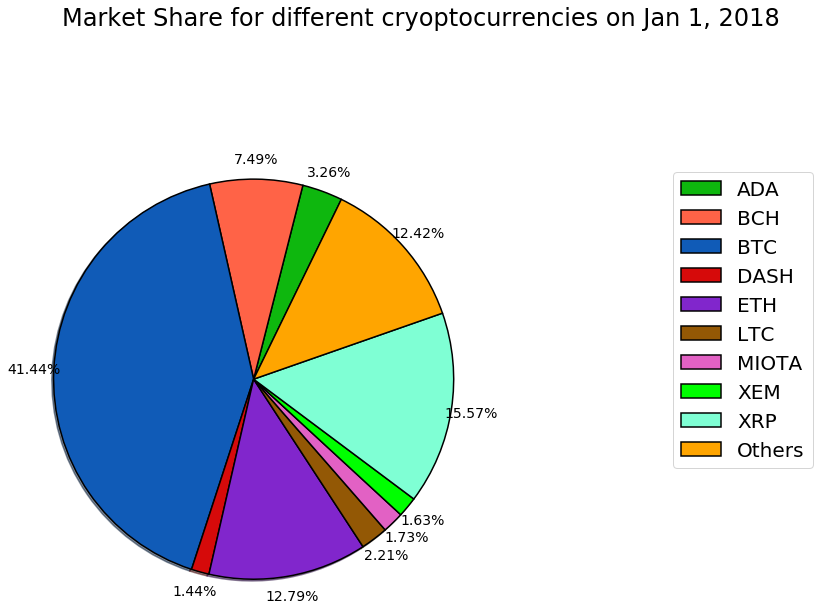

Wall time: 600 ms


In [11]:
%%time
df_2018 = df_Currency[df_Currency['Date'].str.contains("(?:\s|^)2018-01-01(?:\s|$)")]
df_2018 = df_2018.set_index('Symbol')

totalMarCap=sum(df_2018['Market Cap'])
df_Temp=pd.DataFrame({'Market Cap':df_2018['Market Cap'],'Fraction':df_2018['Market Cap']/totalMarCap})
df_High2=df_Temp[df_Temp.Fraction>0.012]
df_Low2=df_Temp[df_Temp.Fraction<=0.012]
df_High2.loc['Others']=df_Low2.sum(axis=0)
df_High2=df_High2.iloc[:,0:3]

#Plotting Pie Charts to show market share of cryptocurrencies on 1st Jan 2018
colors2 = ['#0eb70e', '#ff6347', '#105bb7', '#d60a0a', '#8126cc', '#935805', '#e261c4', '#00FF00', '#7fffd4', '#ffa500']
plt.axis('equal')
texts = plt.pie(df_High2['Market Cap'], shadow=True, radius=2.3, colors=colors2, startangle=64,rotatelabels= True, autopct='%0.2f%%',pctdistance=1.1, textprops={'fontsize': 14}, wedgeprops={"edgecolor":"k",'linewidth': 1.5 , 'antialiased': True})
plt.legend(df_High2.index, bbox_to_anchor=(2.2,1.5), fontsize=20)
plt.title("Market Share for different cryoptocurrencies on Jan 1, 2018", fontsize=24, x=1, y=2.1)
plt.show()

## Part 4: Regression
we run the regression for bitcoin and find that it is dependent on all the 4 parameters taken in to account

In [12]:
%%time
regressForN(read_Data(),1)

################### Regression Model For Currency:  BTC ###################
                            OLS Regression Results                            
Dep. Variable:             Market_Cap   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.318e+06
Date:                Sat, 21 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:06:42   Log-Likelihood:                -10300.
No. Observations:                 473   AIC:                         2.061e+04
Df Residuals:                     468   BIC:                         2.063e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

## Part 5: Clurtering the currencies on basis of their regression results using K means

We regress the dependent variables for different currencies and calculate n number of regression equations for n currencies. This would denote the trendlines for these currencies with respect to the given variables i.e. Open price, market cap, gold price and S&P 500. To find the similarity within these trendlines we cluster them using these beta variables of different currencies with K means clustering. We can then prioritize the clusters that has similar trendline as the popular Bitcooin.

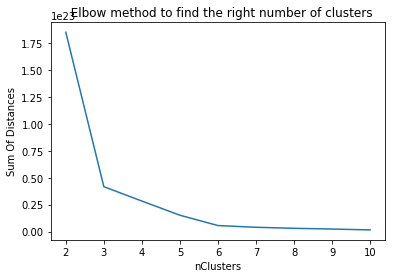

Wall time: 29.1 s


In [44]:
%%time
rel_cols=['Open_Price','Gold_Price','SP500ClosePrice','Volume','Intercept']
t=RegresstoDF(read_Data(),200)
kmeans=KMeans(n_clusters=2).fit(t[rel_cols])
t['Cluster']=kmeans.labels_
nClusters=range(2,11)
sumDistances=[]
for n in nClusters:
    kmeans=KMeans(n_clusters=n).fit(t[rel_cols])
    sumDistances.append(kmeans.inertia_) #Proxy for SSE   
plt.plot(nClusters,sumDistances,'-')
plt.xlabel('nClusters')
plt.ylabel('Sum Of Distances')
plt.title('  Elbow method to find the right number of clusters')
plt.show()

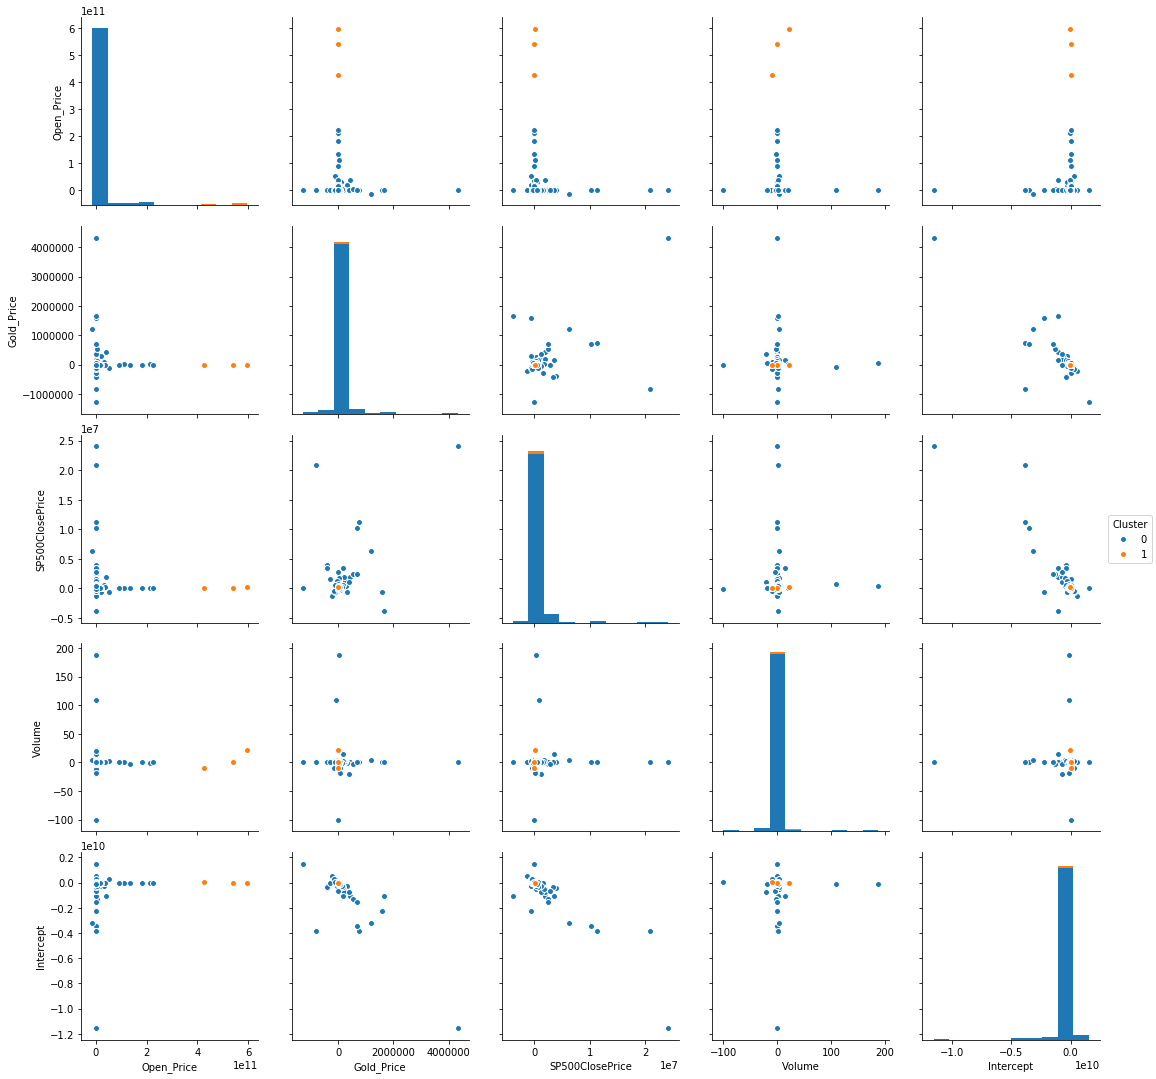

In [45]:
#Observing number of clusters as 3 from the above graph and plotting cluster diagrams
kmeans=KMeans(n_clusters=3).fit(t[rel_cols])
sns.pairplot(data=t,x_vars=rel_cols, y_vars=rel_cols, hue='Cluster', size=3)
plt.show()

### Part 6: Comparing BTC with Top 5 Currencies
We observe the relation in market cap of BTC with top 5 currencies, and variaiton of open price of BTC with top 5 currencies and find that they have similar trends and high correlation with BTC which suggests that the top currency foolow the similar market trend

In [22]:
%%time

alldata=read_Data()
srTopCurrency=alldata.groupby(["Symbol"])['Market_Cap'].mean()
srTop10Currency=srTopCurrency.sort_values(ascending=False)
srTop10Currency=srTop10Currency[1:6]
lsSymbols=[]
for i in range(len(srTop10Currency)):
    lsSymbols.append(srTop10Currency.index[i])

Wall time: 20.8 s


In [23]:
%%time

#Identifying top 5 cryptocurrencies

final_df = alldata[alldata.Symbol == 'BTC']
final_df=final_df[['Date','Open_Price','Market_Cap']]
final_df = final_df.rename(index=str, columns={"Open_Price": ("BTC"+"price"),'Market_Cap':("BTC"+'mktcap')})
for i in lsSymbols:
    Temp = alldata[alldata.Symbol == i]
    Temp=Temp[['Date','Open_Price','Market_Cap']]
    Temp = Temp.rename(index=str, columns={"Open_Price": str((str(i)+"price")),'Market_Cap':(str(i)+'mktcap')})
    Temp=copy.deepcopy(Temp)
    final_df=pd.DataFrame(final_df.merge(Temp, how='inner', left_on="Date", right_on='Date'))   

Wall time: 146 ms


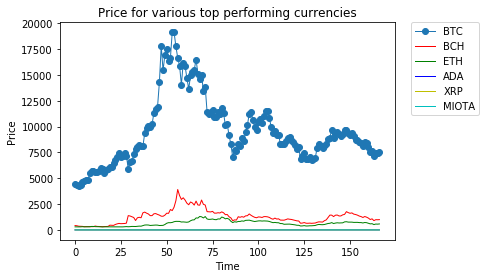

Wall time: 154 ms


In [24]:
%%time
###############
# Draw graphs to see the trends of these currencies' prices
###############

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(final_df['BTCprice'],'o-',linewidth=1,label='BTC')
ax1.plot(final_df['BCHprice'],'r-',linewidth=1,label='BCH')
ax1.plot(final_df['ETHprice'],'g-',linewidth=1,label='ETH')
ax1.plot(final_df['ADAprice'],'b-',linewidth=1,label='ADA')
ax1.plot(final_df['XRPprice'],'y-',linewidth=1,label='XRP')
ax1.plot(final_df['MIOTAprice'],'c-',linewidth=1,label='MIOTA')
plt.title('Price for various top performing currencies')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.show()

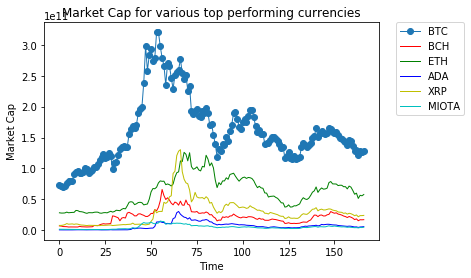

Wall time: 138 ms


In [25]:
%%time
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(final_df['BTCmktcap'],'o-',linewidth=1,label='BTC')
ax1.plot(final_df['BCHmktcap'],'r-',linewidth=1,label='BCH')
ax1.plot(final_df['ETHmktcap'],'g-',linewidth=1,label='ETH')
ax1.plot(final_df['ADAmktcap'],'b-',linewidth=1,label='ADA')
ax1.plot(final_df['XRPmktcap'],'y-',linewidth=1,label='XRP')
ax1.plot(final_df['MIOTAmktcap'],'c-',linewidth=1,label='MIOTA')
plt.title('Market Cap for various top performing currencies')
plt.xlabel('Time')
plt.ylabel('Market Cap')
plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.show()

### Comparing New booming currencies with BTC
We observe the relation in market cap of BTC with 5 New currencies, and variaiton of open price of BTC with 5 new currencies and find that they donot have similar trends and high correlation with BTC which suggests that the new currency would not follow the similar market trend and thus it would not be a good investment 

In [26]:
%%time
ls_new_currency=['SUMO','ITI', "TOR",'MAY','V']
final_df_newCR = alldata[alldata.Symbol == 'BTC']
final_df_newCR=final_df_newCR[['Date','Open_Price','Market_Cap']]
final_df_newCR = final_df_newCR.rename(index=str, columns={"Open_Price": ("BTC"+"price"),'Market_Cap':("BTC"+'mktcap')})
for i in ls_new_currency:
    Temp = alldata[alldata.Symbol == i]
    Temp=Temp[['Date','Open_Price','Market_Cap']]
    Temp = Temp.rename(index=str, columns={"Open_Price": str((str(i)+"price")),'Market_Cap':(str(i)+'mktcap')})
    Temp=copy.deepcopy(Temp)
    final_df_newCR=pd.DataFrame(final_df_newCR.merge(Temp, how='inner', left_on="Date", right_on='Date'))  

Wall time: 137 ms


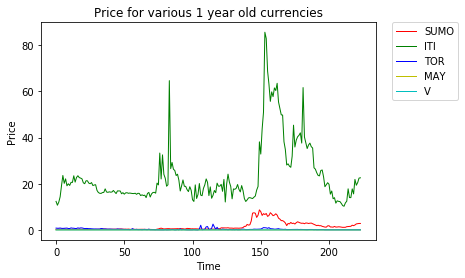

Wall time: 120 ms


In [27]:
%%time
fig=plt.figure()
ax1=fig.add_subplot(111)
#ax1.plot(new5_price['Close'],'o-',linewidth=1,label='BTC')
ax1.plot(final_df_newCR['SUMOprice'],'r-',linewidth=1,label='SUMO')
ax1.plot(final_df_newCR['ITIprice'],'g-',linewidth=1,label='ITI')
ax1.plot(final_df_newCR['TORprice'],'b-',linewidth=1,label='TOR')
ax1.plot(final_df_newCR['MAYprice'],'y-',linewidth=1,label='MAY')
ax1.plot(final_df_newCR['Vprice'],'c-',linewidth=1,label='V')
plt.title('Price for various 1 year old currencies')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.show()

### Part 7: Simulating and Predicting BTC with Black scholes model
we try to predict BTC price with repect to time

In [28]:
%%time
## Defining values for the model
from time import time
S_0 = 7400     # current bitcoin price (from market data) 2018/7/20
K = 7450       #  option strike price (from market data)
T = 1         #  time cycle
r = 0.1       #  risk neutral payoff, assumed 10% for this exercise, in reality probably less
sigma = 0.5    #  rate of fluctuate，BTC sigma should be quite high since it fluctuated so much last year, but currently it seems lessly fluctuate
M = 50         # number of time steps
I = 20000    

Wall time: 0 ns


In [29]:
%time
S = np.zeros((M+1, I))
S[0] = S_0
np.random.seed(2000)
start = time()
dt = T/M       # time interval
for t in range(1, M+1):
    z = np.random.standard_normal(I) #Draw samples from a standard Normal distribution
    #Base on BSM(balck-scholes-merton) model
    S[t] = S[t-1] * np.exp((r- 0.5 * sigma **2)* dt + sigma * np.sqrt(dt)*z) #Using recursing to predict the price based on the price one day before
C_0 = np.exp(-r * T)* np.sum(np.maximum(S[-1] - K, 0))/I
end = time()

Wall time: 0 ns


In [30]:
print ('total time is %.4f seconds'%(end-start))
print ('Option Value %.2f'%C_0)

total time is 0.0479 seconds
Option Value 1744.61


Wall time: 54.9 ms


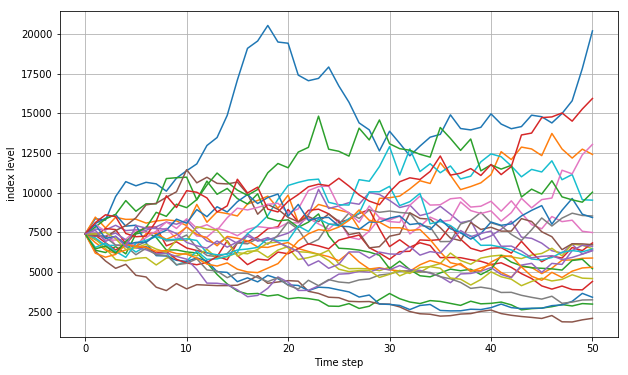

In [31]:
%%time
# draw the probabilities of the price change
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Time step')
plt.ylabel('index level')
for i in range(25):
    plt.plot(S.T[i])

Wall time: 51.9 ms


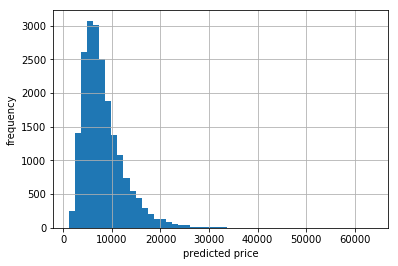

In [32]:
%%time
%matplotlib inline
plt.hist(S[-1], bins=50)
plt.grid(True)
plt.xlabel('predicted price')
plt.ylabel('frequency')

Wall time: 46.9 ms


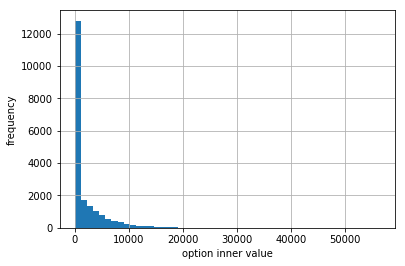

In [33]:
%%time
plt.hist(np.maximum(S[-1]-K, 0), bins=50)
plt.grid(True)
plt.xlabel('option inner value')
plt.ylabel('frequency')

#### Explaination of this part: The first graph shows the probabilities of the top 25 paths from this model. The second graph shows the frequency of the predicted price. From the graph we can see that, the predicted price will fall between 6000 to 8000, and the probability distribution frequency is shown in the histograph. The third graph is the probability distribution frequency of the option inner value.

## Part 8: Profiling with the number of Observations

In [34]:
m =[10, 20, 30, 50, 80, 110, 150, 200] # number of independent variables is varied
times = np.zeros((len(m)))

In [38]:
%%time
for (i, n) in enumerate(m):
    data=read_Data()
    t = measureTime(RegresstoDF, data, i)
    times[i] = t

Wall time: 4min


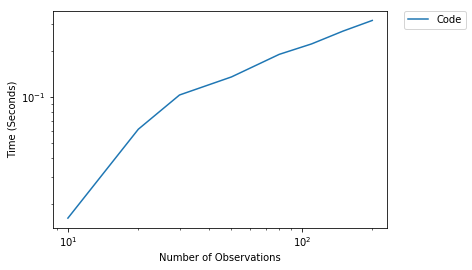

In [40]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.loglog (m, times, '-',label="Code")
plt.xlabel('Number of Observations')
plt.ylabel('Time (Seconds)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

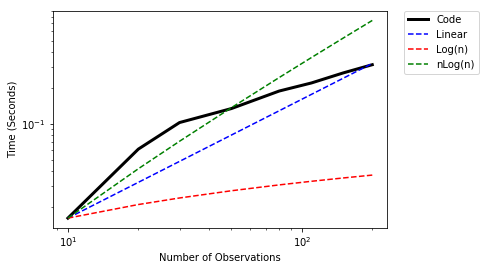

In [41]:
#Create benchmarks
linearTime = [times[0]/m[0]*n for n in m]
lognTime = [times[0]/(np.log(m[0]))*(np.log(n)) for n in m]
nlognTime = [times[0]/(np.log(m[0])*m[0])*(np.log(n))*n for n in m]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.loglog (m, times, 'k-',linewidth=3,label="Code")

#Plot benchmarks
ax1.loglog (m, linearTime, 'b--',label="Linear")
ax1.loglog (m, lognTime, 'r--',label="Log(n)")
ax1.loglog (m, nlognTime , 'g--',label="nLog(n)")
plt.xlabel('Number of Observations')
plt.ylabel('Time (Seconds)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

We observe as the number of variables increases the the time taken by the code reduces.